^C


In [1]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import statsmodels.formula.api as sf
import numpy as np
from sklearn.metrics import mean_squared_error #оценка MSE полученных моделей
from sklearn.model_selection import train_test_split  # метод деления на train/test выборки

In [2]:
#подключение к системе логирования экспериментов neptune.ai
import neptune.new as neptune
run = neptune.init(api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3ZGNjNDU1Ny0xMTEzLTQ3OTItOTkwOC1mZjVkYzAyZjY0M2UifQ==", 
                   project='raygrodno/Ya-test')
# run = neptune.init(
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3ZGNjNDU1Ny0xMTEzLTQ3OTItOTkwOC1mZjVkYzAyZjY0M2UifQ==",
#     project_qualified_name="raygrodno/sandbox"
# )

Info (NVML): Not Supported. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/raygrodno/Ya-test/e/YAT-2


In [3]:
#считываем данные
df = pd.read_excel(r'g:\Yandex\Задание_вып.xls', sheet_name='Мини моделирование', header=1)

In [4]:
#немного переименовываем колонки для удобства работы
df.rename(columns={'Общие конверсии':'Общие_конверсии',
                     'Автобусы/Кинотеатры/Лифты/Метро OTS':'Автобусы',
                     'ООН/Радио/Транспорт/DООН/Digital/Indoor OTS':'ООН',
                  'Интерес к поиску работы':'поиск_работы',
                  'Интерес к бренду':'бренд',
                  'Интерес к брендам конкурентов':'конкуренты',
                  'Индекс самоизоляции':'самоизоляции',
                  'Безработица_Все гео':'Безработица',
                  'Гос праздники + НГ':'праздники',
                  'Созданные компании':'Созданные',
                  'Ликвидированные компании':'Ликвидированные',
                  'Запросы Гугл Трендс':'Гугл_Трендс'}, inplace=True)

In [5]:
y = df['Общие_конверсии']

In [6]:
X0=df.drop(['Общие_конверсии'], axis = 1)

In [7]:
X=df.drop(['Общие_конверсии', 'Дата'], axis = 1)

In [11]:
# сплитим данные на train/test в пропорции 80/20
params = {
            "random_state" : 22
            }
run["parameters/random_state"] = params     # передает данные "random_state" в neptune
X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, 
                                              random_state=params["random_state"])


In [194]:
#Удалим сильно коррелируюшие столбцы - (определили в Excel)
X1=X.drop(['Ликвидированные', 'конкуренты'], axis = 1)
X1_test=X_test.drop(['Ликвидированные', 'конкуренты'], axis = 1)



In [188]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.45), size = 20, xycoords = ax.transAxes)

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


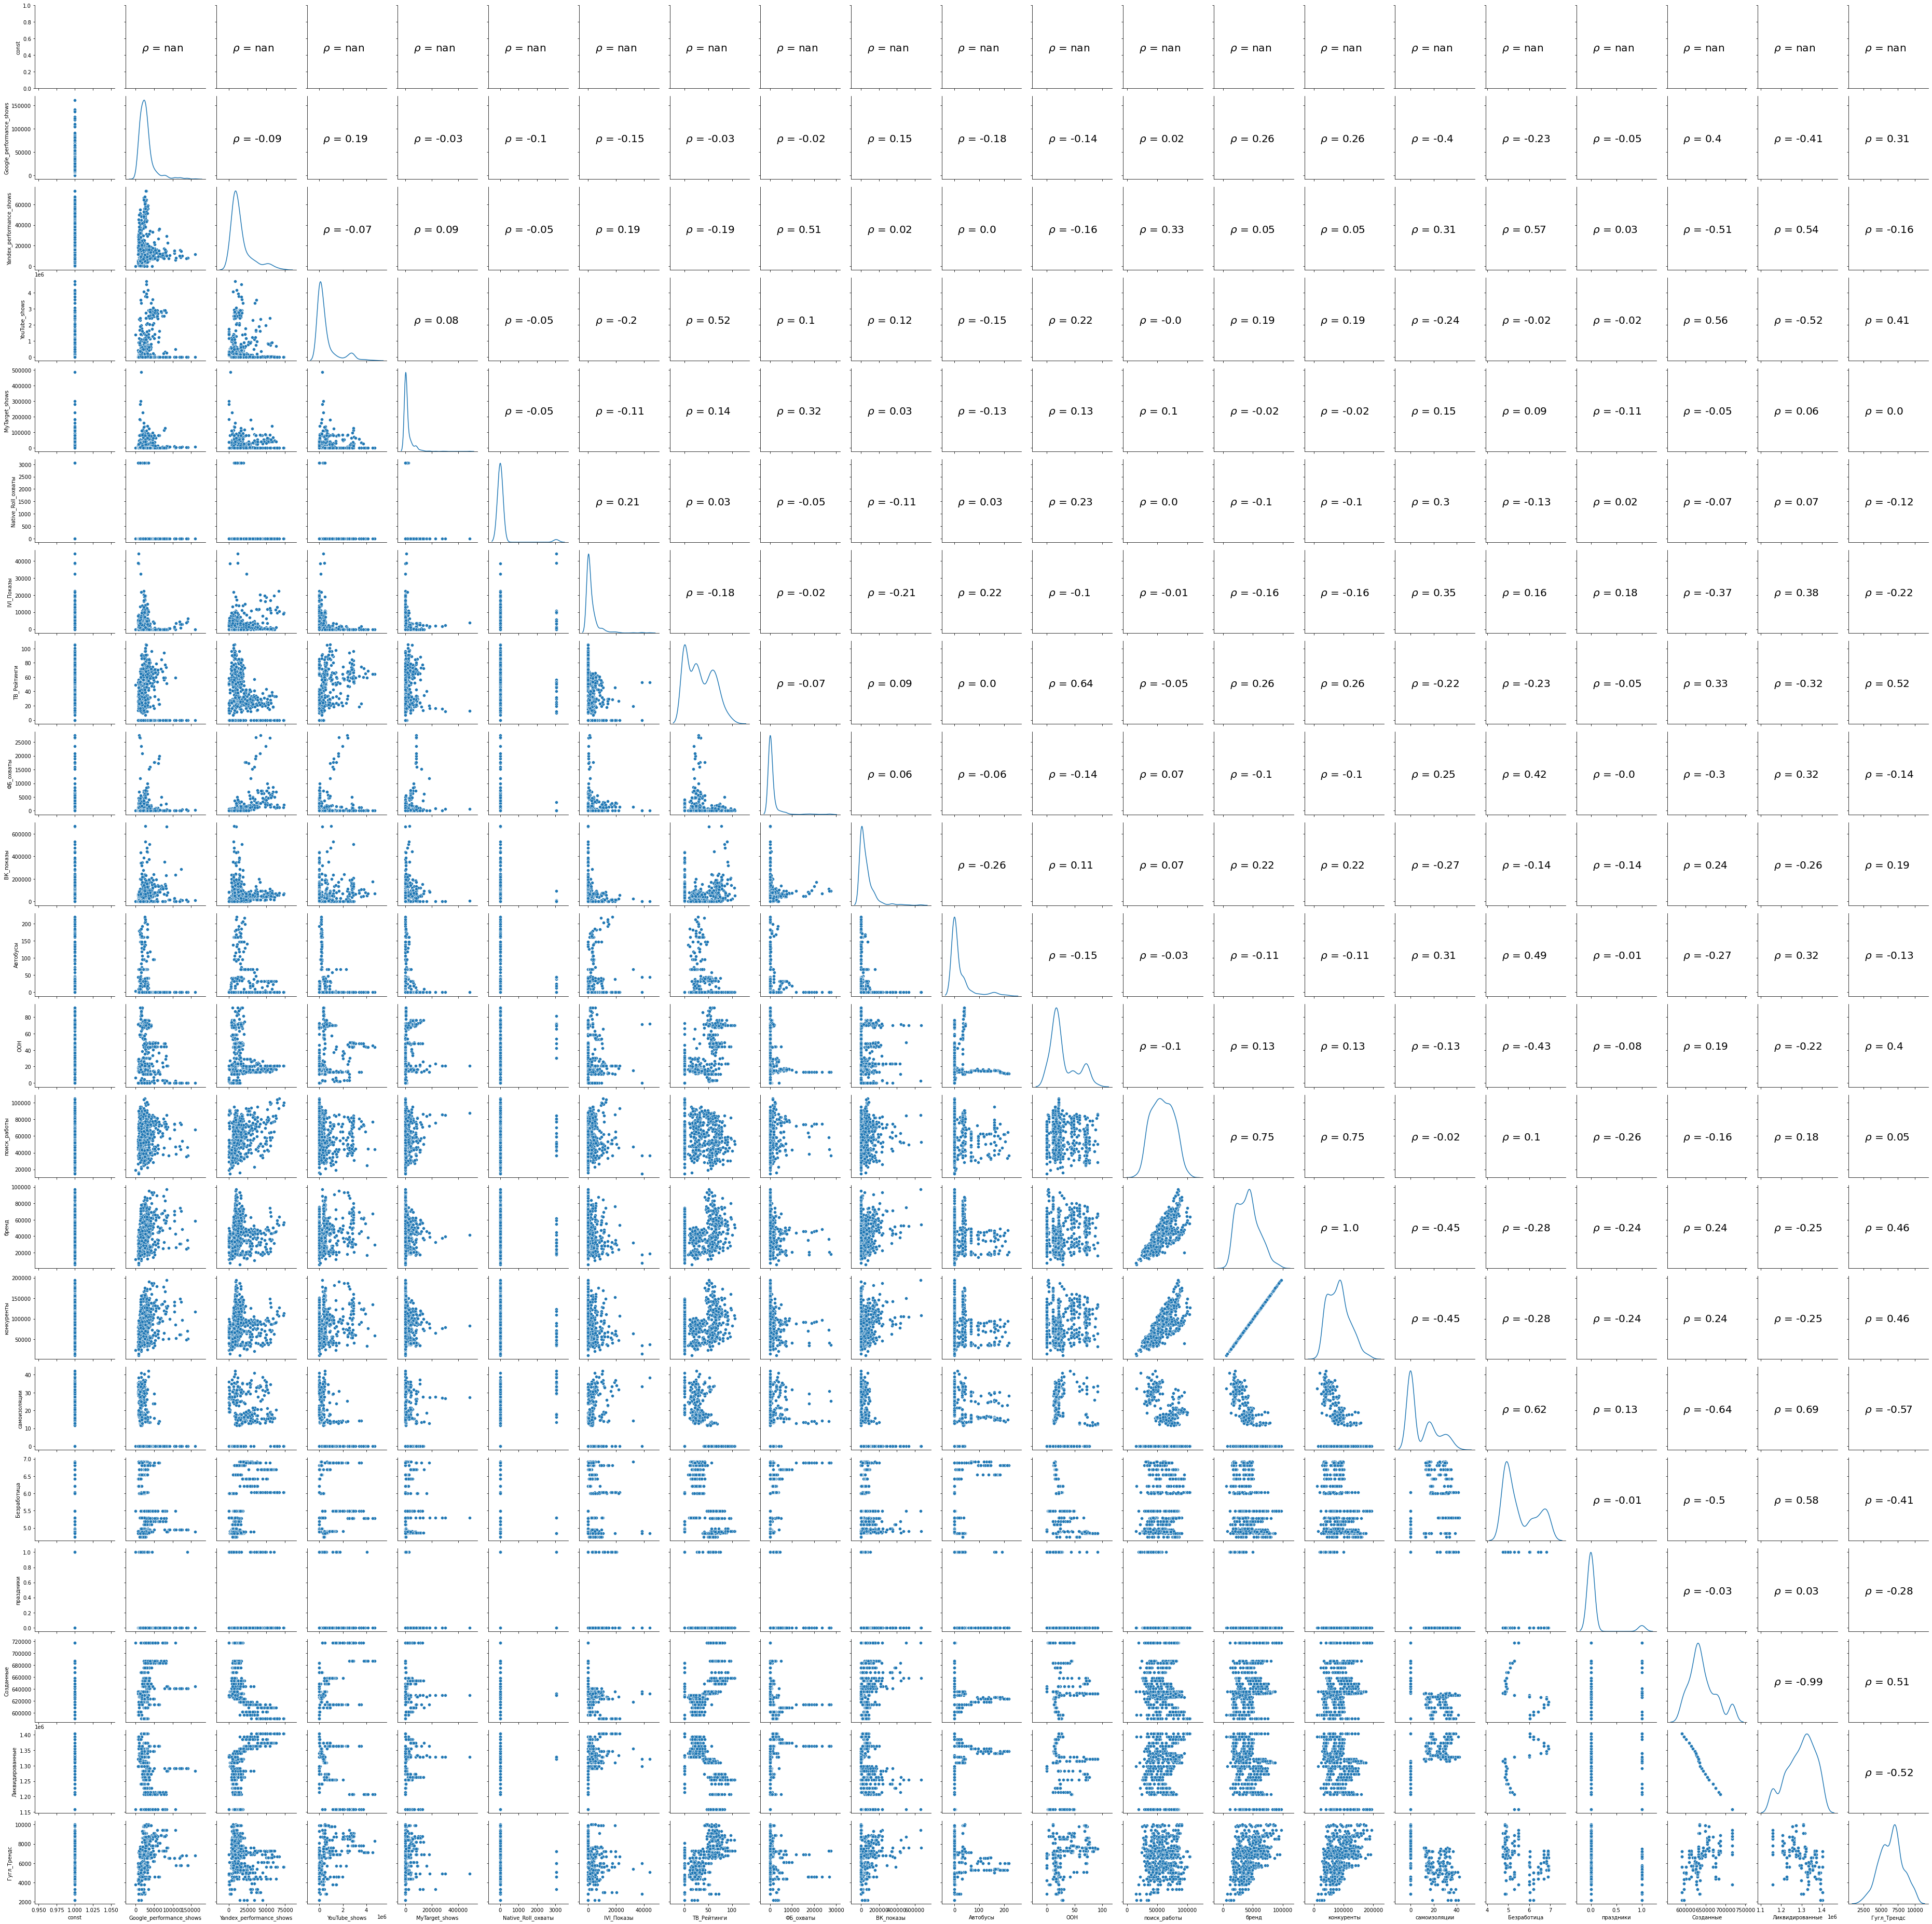

In [189]:
#попарные скаттерплоты независимых переменных

g = sns.PairGrid(X, diag_sharey=False)
# g.map_upper(sns.scatterplot)
g.map_upper(corr)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

<AxesSubplot:>

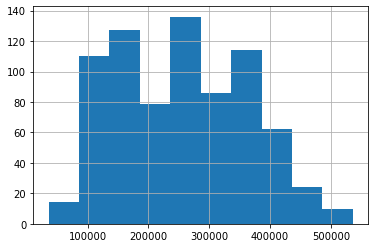

In [108]:
df['Общие_конверсии'].hist()

In [195]:
# модель, построенная со всеми предикторами (в том числе с высоким значением корреляции)

X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Общие_конверсии   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     357.6
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.88e-308
Time:                        09:48:16   Log-Likelihood:                -7138.6
No. Observations:                 609   AIC:                         1.432e+04
Df Residuals:                     589   BIC:                         1.441e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.349e+07   9.48e+05     14.229      0.000    1.16e+07    1.54e+07
Google_performance_shows    -0.1569      0.075     -2.086      0.037      -0.305      -0.009
Yandex_performance_shows     0.5636      0.158      3.560      0.000       0.253       0.875
YouTube_shows               -0.0005      0.002     -0.199      0.842      -0.005       0.004
MyTarget_shows              -0.0519      0.037     -1.421      0.156      -0.124       0.020
Native_Roll_охваты           7.2875      2.813      2.591      0.010       1.763      12.812
IVI_Показы                  -0.3236      0.259     -1.251      0.211      -0.832       0.184
TВ_Рейтинги               -240.9216     77.927     -3.092      0.002    -393.971     -87.873
ФБ_охваты                    1.1339      0.531      2.136      0.033       0.091       2.176
ВК_показы                    0.0517      0.016      3.198      0.001       0.020       0.083
Автобусы                   411.5521     47.894      8.593      0.000     317.488     505.616
ООН                        448.0739     89.132      5.027      0.000     273.019     623.129
поиск_работы                 2.3888      0.172     13.892      0.000       2.051       2.726
бренд                        0.6655      0.036     18.429      0.000       0.595       0.736
конкуренты                   1.3400      0.072     18.591      0.000       1.198       1.482
самоизоляции              1003.2102    226.253      4.434      0.000     558.848    1447.572
Безработица               4.026e+04   4651.960      8.655      0.000    3.11e+04    4.94e+04
праздники                 4177.5208   5991.131      0.697      0.486   -7589.059    1.59e+04
Созданные                   -9.8715      0.720    -13.708      0.000     -11.286      -8.457
Ликвидированные             -5.7278      0.388    -14.753      0.000      -6.490      -4.965
Гугл_Трендс                  0.0931      1.198      0.078      0.938      -2.259       2.445
==============================================================================
Omnibus:                        8.920   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.873
Skew:                           0.275   Prob(JB):                       0.0118
Kurtosis:                       3.216   Cond. No.                     7.47e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.71e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [196]:
X_test = sm.add_constant(X_test) ## let's add an intercept (beta_0) to our model

predictions = model.predict(X_test)


#оценка метрики MSE на тестовой выборке

current_MSE = mean_squared_error(y_test, predictions)
run["MSE"].log(current_MSE)
current_MSE

1080659689.7288606

In [197]:
# модель, построенная без сильно коррелирующих предикторов (Rxy>0,9) и даты.

X1 = sm.add_constant(X1) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X1).fit() ## sm.OLS(output, input)
predictions = model.predict(X1)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Общие_конверсии   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     267.2
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.43e-269
Time:                        09:48:55   Log-Likelihood:                -7234.4
No. Observations:                 609   AIC:                         1.451e+04
Df Residuals:                     590   BIC:                         1.459e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -4.736e+05   6.36e+04     -7.451      0.000   -5.98e+05   -3.49e+05
Google_performance_shows    -0.0046      0.087     -0.053      0.958      -0.176       0.166
Yandex_performance_shows     0.2564      0.184      1.397      0.163      -0.104       0.617
YouTube_shows               -0.0019      0.003     -0.680      0.497      -0.007       0.004
MyTarget_shows              -0.0250      0.043     -0.585      0.559      -0.109       0.059
Native_Roll_охваты           4.5076      3.282      1.373      0.170      -1.938      10.953
IVI_Показы                  -0.8149      0.300     -2.717      0.007      -1.404      -0.226
TВ_Рейтинги               -525.0258     88.292     -5.946      0.000    -698.430    -351.621
ФБ_охваты                    0.6112      0.619      0.987      0.324      -0.605       1.827
ВК_показы                    0.0978      0.019      5.278      0.000       0.061       0.134
Автобусы                   227.5292     54.068      4.208      0.000     121.339     333.719
ООН                        745.4152    101.520      7.343      0.000     546.031     944.799
поиск_работы                 1.3461      0.183      7.344      0.000       0.986       1.706
бренд                        3.9663      0.205     19.352      0.000       3.564       4.369
самоизоляции              -629.2359    230.754     -2.727      0.007   -1082.434    -176.038
Безработица               6477.1918   4734.602      1.368      0.172   -2821.534    1.58e+04
праздники                -9596.6484   6919.660     -1.387      0.166   -2.32e+04    3993.515
Созданные                    0.6884      0.092      7.460      0.000       0.507       0.870
Гугл_Трендс                 -1.0395      1.398     -0.744      0.457      -3.784       1.705
==============================================================================
Omnibus:                       42.528   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.231
Skew:                           0.530   Prob(JB):                     1.86e-14
Kurtosis:                       4.169   Cond. No.                     4.80e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [198]:
X1_test = sm.add_constant(X1_test) ## let's add an intercept (beta_0) to our model

predictions = model.predict(X1_test)


#оценка метрики MSE на тестовой выборке

mean_squared_error(y_test, predictions)

1045139644.5042224

Исключим из модели статистически незначимые предикторы (p>0,05)

In [199]:

X1=X1.drop(['Google_performance_shows', 'YouTube_shows', 'MyTarget_shows', 'Гугл_Трендс', \
            'Безработица','ФБ_охваты','Native_Roll_охваты'], axis = 1)
X1_test=X1_test.drop(['Google_performance_shows', 'YouTube_shows', 'MyTarget_shows', 'Гугл_Трендс', \
            'Безработица','ФБ_охваты','Native_Roll_охваты'], axis = 1)

In [200]:
X1 = sm.add_constant(X1) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X1).fit() ## sm.OLS(output, input)
predictions = model.predict(X1)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Общие_конверсии   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     437.8
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          2.63e-277
Time:                        09:50:45   Log-Likelihood:                -7237.3
No. Observations:                 609   AIC:                         1.450e+04
Df Residuals:                     597   BIC:                         1.455e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -4.336e+05   4.62e+04     -9.392      0.000   -5.24e+05   -3.43e+05
Yandex_performance_shows     0.4071      0.129      3.146      0.002       0.153       0.661
IVI_Показы                  -0.8556      0.288     -2.966      0.003      -1.422      -0.289
TВ_Рейтинги               -538.3292     74.841     -7.193      0.000    -685.312    -391.346
ВК_показы                    0.1043      0.018      5.806      0.000       0.069       0.140
Автобусы                   266.1662     41.858      6.359      0.000     183.959     348.374
ООН                        687.0642     85.056      8.078      0.000     520.018     854.110
поиск_работы                 1.4044      0.165      8.532      0.000       1.081       1.728
бренд                        3.8536      0.181     21.299      0.000       3.498       4.209
самоизоляции              -375.5281    181.938     -2.064      0.039    -732.844     -18.212
праздники                -9957.8744   6373.229     -1.562      0.119   -2.25e+04    2558.800
Созданные                    0.6672      0.068      9.745      0.000       0.533       0.802
==============================================================================
Omnibus:                       37.880   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.746
Skew:                           0.507   Prob(JB):                     3.52e-12
Kurtosis:                       4.024   Cond. No.                     2.09e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [201]:
X1_test = sm.add_constant(X1_test) ## let's add an intercept (beta_0) to our model

predictions = model.predict(X1_test)


#оценка метрики MSE на тестовой выборке

mean_squared_error(y_test, predictions)

1055646357.6883584

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


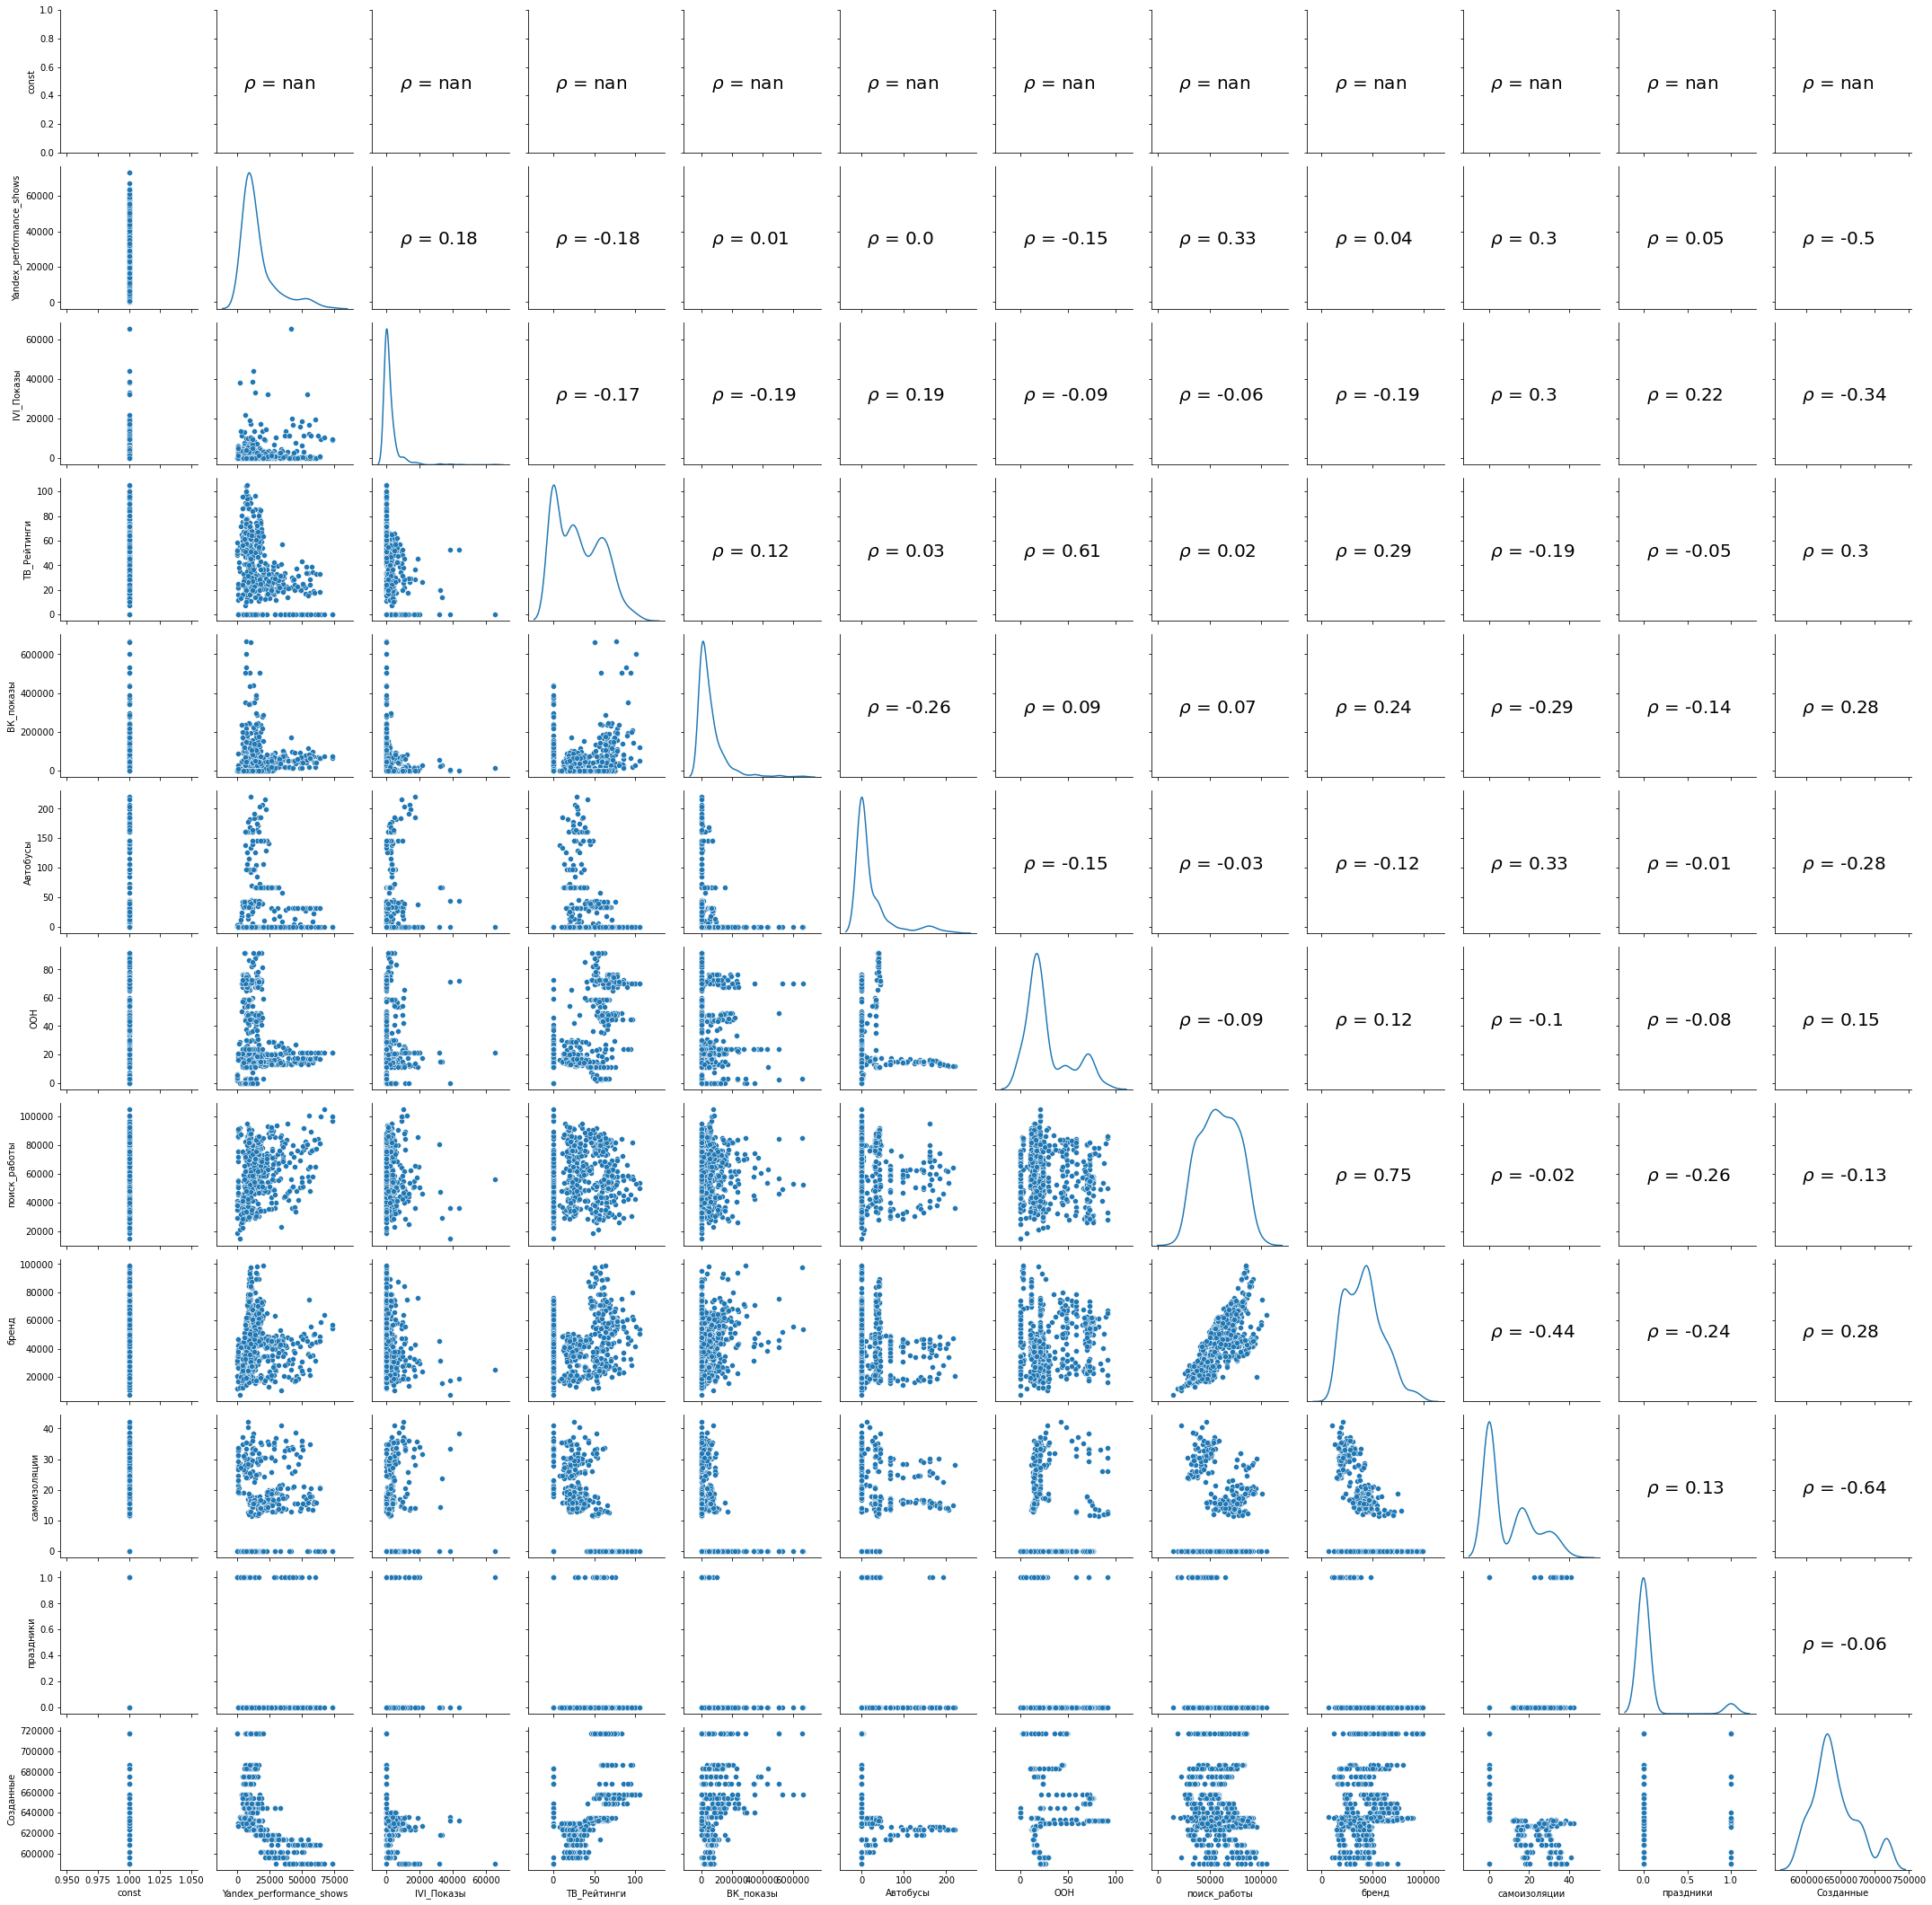

In [16]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.45), size = 20, xycoords = ax.transAxes)

g = sns.PairGrid(X1, diag_sharey=False)
# g.map_upper(sns.scatterplot)
g.map_upper(corr)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

In [202]:
# прологарифмируем предикторы, имеющие нулевые (добавим 0.001 для исключения абсолютных нулей) и большие ненулевые значения
X1['Yandex_performance_shows'] = X1['Yandex_performance_shows'].apply(lambda x:np.log(x+0.001))


X1['IVI_Показы'] = X1['IVI_Показы'].apply(lambda x:np.log(x+0.001))
X1['ВК_показы'] = X1['ВК_показы'].apply(lambda x:np.log(x+0.001))
X1.rename(columns={'Yandex_performance_shows':'log_Yandex_performance_shows',
                  'IVI_Показы':'log_IVI_Показы',
                   'ВК_показы':'log_ВК_показы' }, inplace=True)
                  
#X1['Автобусы'] = X1['Автобусы'].apply(lambda x:np.log(x+0.001))
#X1['самоизоляции'] = X1['самоизоляции'].apply(lambda x:np.log(x+0.001))

In [203]:
# прологарифмируем тестовые предикторы, имеющие нулевые (добавим 0.001 для исключения абсолютных нулей) и большие ненулевые значения
X1_test['Yandex_performance_shows'] = X1_test['Yandex_performance_shows'].apply(lambda x:np.log(x+0.001))


X1_test['IVI_Показы'] = X1_test['IVI_Показы'].apply(lambda x:np.log(x+0.001))
X1_test['ВК_показы'] = X1_test['ВК_показы'].apply(lambda x:np.log(x+0.001))
X1_test.rename(columns={'Yandex_performance_shows':'log_Yandex_performance_shows',
                  'IVI_Показы':'log_IVI_Показы',
                   'ВК_показы':'log_ВК_показы' }, inplace=True)
                  
#X1['Автобусы'] = X1['Автобусы'].apply(lambda x:np.log(x+0.001))
#X1['самоизоляции'] = X1['самоизоляции'].apply(lambda x:np.log(x+0.001))

In [120]:
X1

,const,log_Yandex_performance_shows,log_IVI_Показы,TВ_Рейтинги,log_ВК_показы,Автобусы,ООН,поиск_работы,бренд,самоизоляции,праздники,Созданные
650,1.0,10.988272,-6.907755,17.920000,10.666068,31.92,17.520833,83724.8,50496,16.002968,0,608735
206,1.0,8.793592,-6.907755,100.237143,10.187237,0.00,70.132548,42264.6,41394,0.000000,0,658051
617,1.0,10.412946,7.408531,34.200000,9.855295,38.40,13.093000,68568.8,45834,13.780323,0,614199
254,1.0,8.876312,-6.907755,71.564444,11.854492,0.00,67.411509,58774.8,52422,0.000000,0,648817
329,1.0,9.383537,7.538070,0.000000,11.541834,0.00,0.000000,76007.6,62958,0.000000,0,640637
...,...,...,...,...,...,...,...,...,...,...,...,...
491,1.0,6.406992,8.542354,0.000000,9.309552,0.00,20.769333,72238.0,38088,23.096804,0,626638
502,1.0,6.166540,8.458971,0.000000,-6.907755,0.00,16.465270,47025.6,20766,30.933571,0,626638
358,1.0,8.566479,-6.907755,0.000000,8.540519,0.00,0.000000,51089.8,34914,0.000000,0,635966
356,1.0,8.723123,4.547552,0.000000,9.638350,0.00,0.000000,60307.2,43884,0.000000,0,635966


In [204]:
X1 = sm.add_constant(X1) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X1).fit() ## sm.OLS(output, input)
predictions = model.predict(X1)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Общие_конверсии   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     503.2
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          1.81e-293
Time:                        09:52:27   Log-Likelihood:                -7199.2
No. Observations:                 609   AIC:                         1.442e+04
Df Residuals:                     597   BIC:                         1.448e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -4.762e+05   4.98e+04     -9.567      0.000   -5.74e+05   -3.78e+05
log_Yandex_performance_shows  5868.4539   1049.854      5.590      0.000    3806.598    7930.309
log_IVI_Показы               -1515.9084    321.413     -4.716      0.000   -2147.145    -884.671
TВ_Рейтинги                   -436.3296     70.221     -6.214      0.000    -574.240    -298.419
log_ВК_показы                 1141.1047    207.583      5.497      0.000     733.422    1548.787
Автобусы                       311.2610     41.278      7.541      0.000     230.192     392.330
ООН                            545.2627     81.263      6.710      0.000     385.667     704.858
поиск_работы                     1.6057      0.154     10.399      0.000       1.302       1.909
бренд                            3.7676      0.171     22.082      0.000       3.432       4.103
самоизоляции                  -168.0995    178.468     -0.942      0.347    -518.601     182.402
праздники                    -2688.6304   6026.396     -0.446      0.656   -1.45e+04    9146.883
Созданные                        0.6404      0.070      9.147      0.000       0.503       0.778
==============================================================================
Omnibus:                       32.680   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.944
Skew:                           0.434   Prob(JB):                     3.88e-11
Kurtosis:                       4.066   Cond. No.                     2.39e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

получили модель с более высоким уточненным R2 (0.903), но с болеетяжелой интерпретацией 
(log-предикторы: при изменении на 1% получаем изменение абсолютное изменение ЗП на coef/100 единиц)

При этом "индекс самоизоляции" и "праздники" стали статистически незначимыми.

In [205]:
X1_test = sm.add_constant(X1_test) ## let's add an intercept (beta_0) to our model

predictions = model.predict(X1_test)




#оценка метрики MSE на тестовой выборке

mean_squared_error(y_test, predictions)

1054024125.5102382

In [206]:
X1=X1.drop(['самоизоляции', 'праздники'], axis = 1)
X1_test=X1_test.drop(['самоизоляции', 'праздники'], axis = 1)

In [207]:
X1 = sm.add_constant(X1) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X1).fit() ## sm.OLS(output, input)
predictions = model.predict(X1)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Общие_конверсии   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     615.7
Date:                Wed, 28 Apr 2021   Prob (F-statistic):          5.39e-296
Time:                        09:53:06   Log-Likelihood:                -7199.9
No. Observations:                 609   AIC:                         1.442e+04
Df Residuals:                     599   BIC:                         1.446e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -4.91e+05   4.77e+04    -10.297      0.000   -5.85e+05   -3.97e+05
log_Yandex_performance_shows  5963.3104   1029.515      5.792      0.000    3941.414    7985.207
log_IVI_Показы               -1595.5827    306.359     -5.208      0.000   -2197.251    -993.915
TВ_Рейтинги                   -442.5540     69.922     -6.329      0.000    -579.877    -305.231
log_ВК_показы                 1134.1315    205.287      5.525      0.000     730.962    1537.301
Автобусы                       307.4879     40.607      7.572      0.000     227.738     387.237
ООН                            541.2138     80.148      6.753      0.000     383.809     698.619
поиск_работы                     1.5739      0.145     10.841      0.000       1.289       1.859
бренд                            3.8395      0.151     25.433      0.000       3.543       4.136
Созданные                        0.6583      0.068      9.680      0.000       0.525       0.792
==============================================================================
Omnibus:                       32.117   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.967
Skew:                           0.421   Prob(JB):                     3.84e-11
Kurtosis:                       4.086   Cond. No.                     2.29e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [208]:
X1_test = sm.add_constant(X1_test) ## let's add an intercept (beta_0) to our model

predictions = model.predict(X1_test)




#оценка метрики MSE на тестовой выборке

mean_squared_error(y_test, predictions)

1058056947.2674747

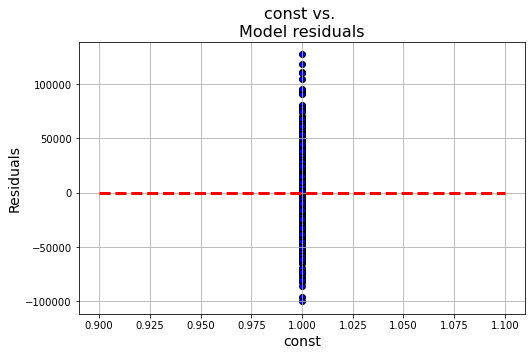

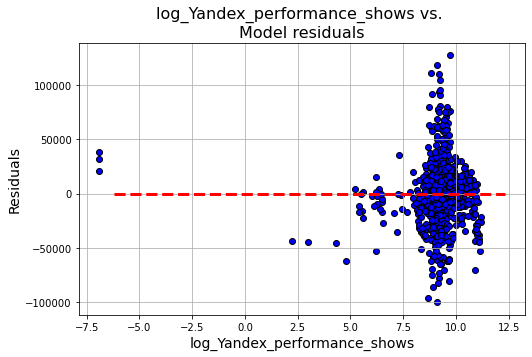

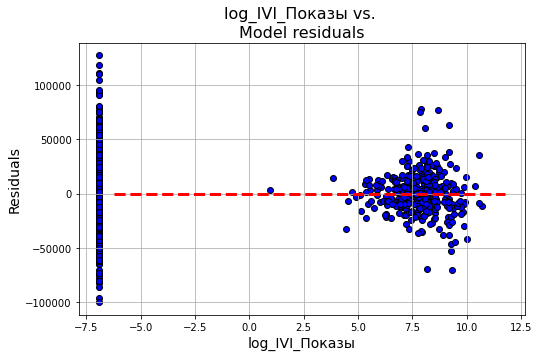

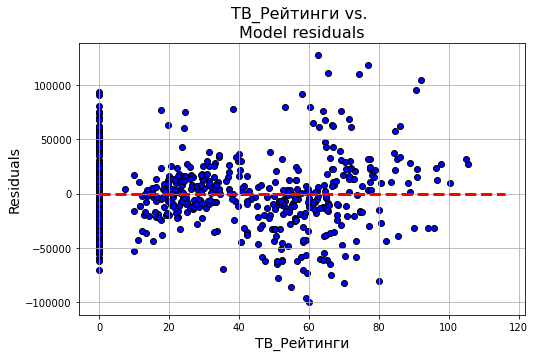

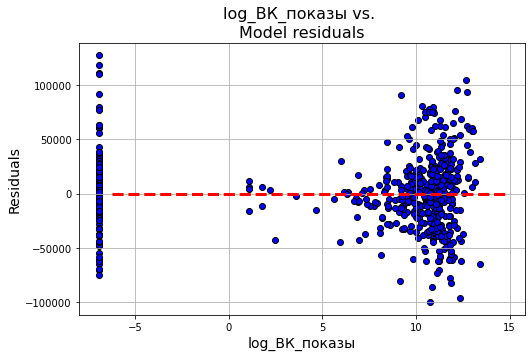

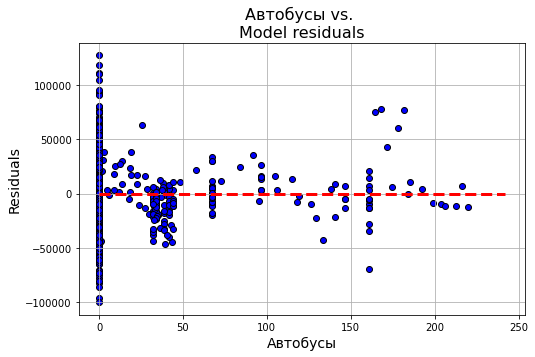

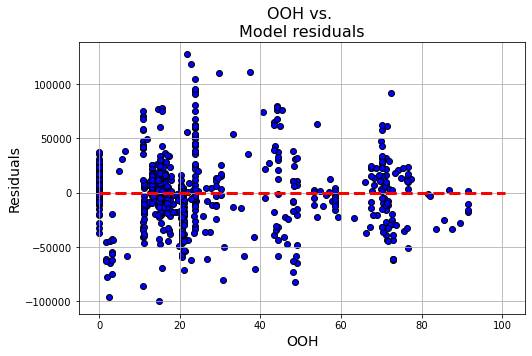

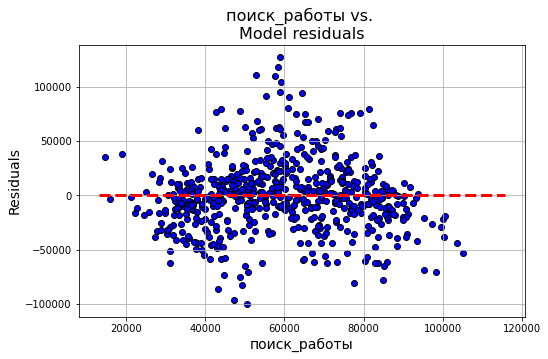

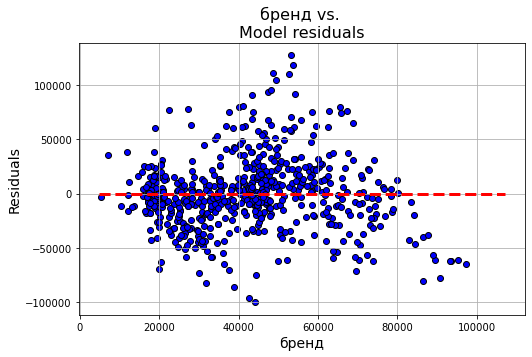

In [168]:
#графики рапределения остатков
for c in X1.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=X1[c],y=model.resid,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(X1[c])
    xmax = max(X1[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()


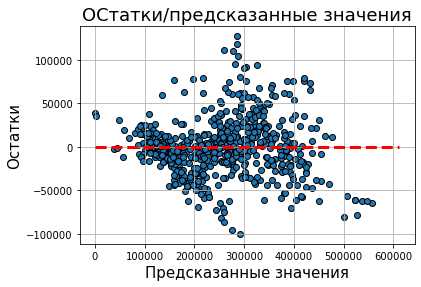

In [169]:
# график зависмости остатков от предсказанных занчений - должен 
p=plt.scatter(x=model.fittedvalues,y=model.resid,edgecolor='k')
xmin=min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Предсказанные значения",fontsize=15)
plt.ylabel("Остатки",fontsize=15)
plt.title("ОСтатки/предсказанные значения",fontsize=18)
plt.grid(True)
plt.show()


ГЕТЕРОСКЕДАСТИЧНОСТЬ????????

In [171]:
from statsmodels.graphics.gofplots import qqplot

<Figure size 576x360 with 0 Axes>

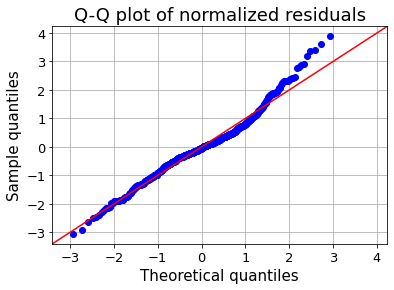

In [172]:
# -QQ-plot для остатков
plt.figure(figsize=(8,5))
fig=qqplot(model.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

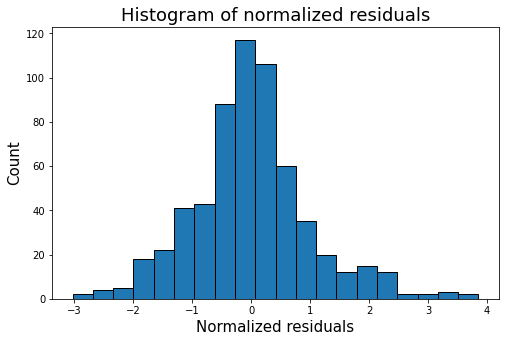

In [173]:
# ГИСТОГРАММА ОСТАТКОВ
plt.figure(figsize=(8,5))
plt.hist(model.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

In [174]:
from scipy.stats import shapiro

In [175]:
#тест Шапиро-Уилка для остатков
_,p=shapiro(model.resid)

In [176]:
p

1.4244285750919516e-08

Результаты теста показывают, что остатки распределены НЕ нормально (p<<0.01)

In [177]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [178]:
for i in range(len(X1.columns[:-1])):
    v=vif(np.matrix(X1[:-1]),i)
    print("Variance inflation factor for {}: {}".format(X1.columns[i],round(v,2)))

Variance inflation factor for const: 1263.39
Variance inflation factor for log_Yandex_performance_shows: 1.4
Variance inflation factor for log_IVI_Показы: 2.89
Variance inflation factor for TВ_Рейтинги: 2.05
Variance inflation factor for log_ВК_показы: 1.44
Variance inflation factor for Автобусы: 1.39
Variance inflation factor for ООН: 1.88
Variance inflation factor for поиск_работы: 3.75
Variance inflation factor for бренд: 3.93


Все VIF < 10, что говорит об отстутсвии мультиколлинеарности в данных.

In [179]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [180]:
inf=influence(model)

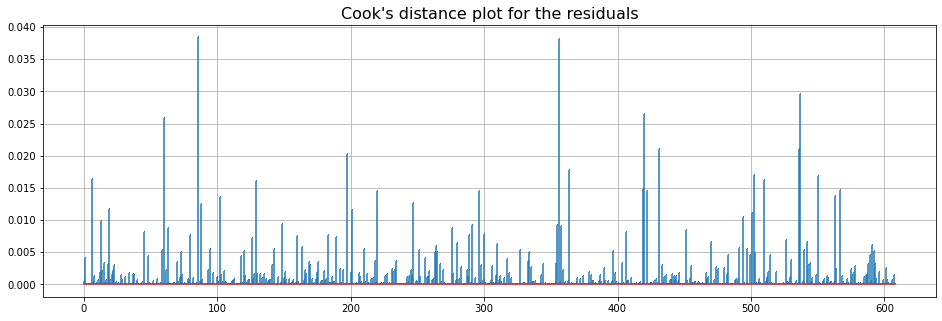

In [181]:
(c, p) = inf.cooks_distance
plt.figure(figsize=(16,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()